In [ ]:
import functools
import sys
!pip install datasets
import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 5.2 MB/s 
     |████████████████████████████████| 86 kB 4.3 MB/s 
     |████████████████████████████████| 86 kB 4.9 MB/s 
     |████████████████████████████████| 212 kB 64.3 MB/s 
     |████████████████████████████████| 140 kB 65.3 MB/s 
     |████████████████████████████████| 1.1 MB 71.2 MB/s 
     |████████████████████████████████| 596 kB 71.3 MB/s 
     |████████████████████████████████| 127 kB 70.3 MB/s 
     |████████████████████████████████| 144 kB 68.2 MB/s 
     |████████████████████████████████| 94 kB 278 kB/s 
     |████████████████████████████████| 271 kB 92.6 MB/s 
     |████████████████████████████████| 112 kB 80.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing ins

In [ ]:
seed = 0

torch.manual_seed(seed)

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/drive')

Mounted at /drive


In [ ]:
train_data, test_data = datasets.load_dataset('imdb', split=['train', 'test'])

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
train_data

Dataset({
    features: ['text', 'label', 'tokens', 'length', 'ids'],
    num_rows: 18750
})

In [ ]:
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

In [ ]:
def tokenize_data(example, tokenizer, max_length):
    tokens = tokenizer(example['text'])[:max_length]
    length = len(tokens)
    return {'tokens': tokens, 'length': length}

In [ ]:
max_length = 256

train_data = train_data.map(tokenize_data, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})
test_data = test_data.map(tokenize_data, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})

  0%|          | 0/25000 [00:00<?, ?ex/s]

  0%|          | 0/25000 [00:00<?, ?ex/s]

In [ ]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data['train']
valid_data = train_valid_data['test']

In [ ]:
min_freq = 5
special_tokens = ['<unk>', '<pad>']

vocab = torchtext.vocab.build_vocab_from_iterator(train_data['tokens'],
                                                  min_freq=min_freq,
                                                  specials=special_tokens)

In [ ]:
unk_index = vocab['<unk>']
pad_index = vocab['<pad>']

In [ ]:
vocab.set_default_index(unk_index)
def numericalize_data(example, vocab):
    ids = [vocab[token] for token in example['tokens']]
    return {'ids': ids}
train_data = train_data.map(numericalize_data, fn_kwargs={'vocab': vocab})
valid_data = valid_data.map(numericalize_data, fn_kwargs={'vocab': vocab})
test_data = test_data.map(numericalize_data, fn_kwargs={'vocab': vocab})

  0%|          | 0/18750 [00:00<?, ?ex/s]

  0%|          | 0/6250 [00:00<?, ?ex/s]

  0%|          | 0/25000 [00:00<?, ?ex/s]

In [ ]:
train_data = train_data.with_format(type='torch', columns=['ids', 'label', 'length'])
valid_data = valid_data.with_format(type='torch', columns=['ids', 'label', 'length'])
test_data = test_data.with_format(type='torch', columns=['ids', 'label', 'length'])
train_data[0]

{'ids': tensor([   34,     7,    61,  2273,   354,  8339,    75,    14,   486,     4,
             6,    11,    10,   108,  1492,   265,    36,    11,  3141,     2,
          1299,     7,     5,   337,   486,     4,    22,    26,    31,     8,
           904,    92,     8,    90,  3024,     7,  5971,  1145,    15,  4923,
            26,     8,  1018,     6,   499,   135,  1007,    96,    37,  2531,
             7,  2213,  9704,     4,     6,    26,    31,     8,  1689,  1454,
          1917,  2116,    21,  1914,  4123,     4,     8,  4511,   135,     9,
           657,     9,    36,    26,    99,    31,     8,   172,   141, 11431,
          1548, 18356,  8391,  1605,     4,    15,  4923,    26,     8,    90,
           222,  1219, 11121,     8,    88,   109,    36,     6,    12,   225,
            71,    69,     8,   923,   299,    36,    36,    36,    36,    36,
           307,    52,    26,    31,    66,   124,     0,    59,   844,   346,
            37,     2,    65,    26,   250,  

In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional,
                 dropout_rate, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional,
                            dropout=dropout_rate, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, ids, length):
        # ids = [batch size, seq len]
        # length = [batch size]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, length, batch_first=True, 
                                                            enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output = [batch size, seq len, hidden dim * n directions]
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            # hidden = [batch size, hidden dim * 2]
        else:
            hidden = self.dropout(hidden[-1])
            # hidden = [batch size, hidden dim]
        prediction = self.fc(hidden)
        # prediction = [batch size, output dim]
        return prediction

In [ ]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique('label'))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout_rate, 
             pad_index)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 10,049,402 trainable parameters


In [ ]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

In [ ]:
model.apply(initialize_weights)

LSTM(
  (embedding): Embedding(21462, 300, padding_idx=1)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=600, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
vectors = torchtext.vocab.FastText()

.vector_cache/wiki.en.vec: 6.60GB [02:12, 50.0MB/s]                            
100%|██████████| 2519370/2519370 [03:35<00:00, 11707.70it/s]


In [ ]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
model.embedding.weight.data = pretrained_embedding
lr = 5e-4

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def collate(batch, pad_index):
    batch_ids = [i['ids'] for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_length = [i['length'] for i in batch]
    batch_length = torch.stack(batch_length)
    batch_label = [i['label'] for i in batch]
    batch_label = torch.stack(batch_label)
    batch = {'ids': batch_ids,
             'length': batch_length,
             'label': batch_label}
    return batch

In [ ]:
batch_size = 512

collate = functools.partial(collate, pad_index=pad_index)

train_dataloader = torch.utils.data.DataLoader(train_data, 
                                               batch_size=batch_size, 
                                               collate_fn=collate, 
                                               shuffle=True)

valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn=collate)

In [ ]:
def train(dataloader, model, criterion, optimizer, device):

    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(dataloader, desc='training...', file=sys.stdout):
        ids = batch['ids'].to(device)
        length = batch['length']
        label = batch['label'].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [ ]:
def evaluate(dataloader, model, criterion, device):
    
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)
            length = batch['length']
            label = batch['label'].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [ ]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [ ]:
n_epochs = 10
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(n_epochs):

    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)
    
    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)
    
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'lstm.pt')
    
    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')

evaluating...: 100%|██████████| 13/13 [00:41<00:00,  3.15s/it]
epoch: 1
train_loss: 0.641, train_acc: 0.626
valid_loss: 0.702, valid_acc: 0.577
evaluating...: 100%|██████████| 13/13 [00:40<00:00,  3.12s/it]
epoch: 2
train_loss: 0.572, train_acc: 0.706
valid_loss: 0.562, valid_acc: 0.690
evaluating...: 100%|██████████| 13/13 [00:40<00:00,  3.13s/it]
epoch: 3
train_loss: 0.465, train_acc: 0.783
valid_loss: 0.356, valid_acc: 0.850
evaluating...: 100%|██████████| 13/13 [00:41<00:00,  3.16s/it]
epoch: 4
train_loss: 0.385, train_acc: 0.831
valid_loss: 0.414, valid_acc: 0.818
evaluating...: 100%|██████████| 13/13 [00:40<00:00,  3.15s/it]
epoch: 5
train_loss: 0.342, train_acc: 0.857
valid_loss: 0.322, valid_acc: 0.866
evaluating...: 100%|██████████| 13/13 [00:40<00:00,  3.12s/it]
epoch: 6
train_loss: 0.312, train_acc: 0.871
valid_loss: 0.343, valid_acc: 0.855
evaluating...: 100%|██████████| 13/13 [00:40<00:00,  3.13s/it]
epoch: 7
train_loss: 0.273, train_acc: 0.889
valid_loss: 0.365, valid_acc

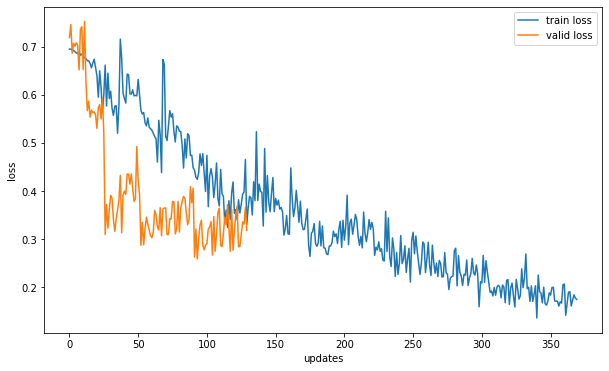

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss');

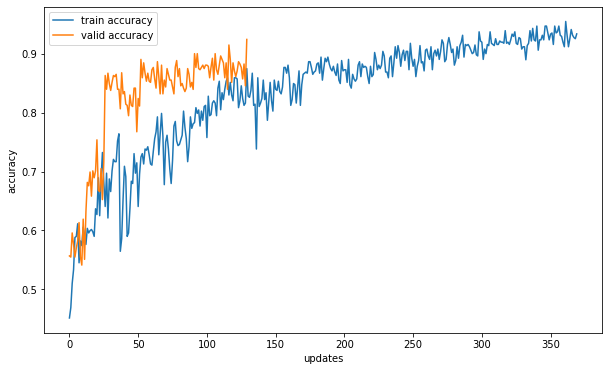

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='train accuracy')
ax.plot(valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('accuracy');

In [ ]:
# print(history['train_acc'])
# print(history['val_acc'])

# new_tensor = torch.tensor(history['train_acc'], device = 'cpu')
# print(new_tensor)

plt.plot(train_accs, label='train accuracy')
plt.plot(valid_accs, label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.1, 1]);
plt.xlim([0, 10]);

NameError: ignored